In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

## Test Signal

In [2]:
N = 1024
n = np.arange(N)
F = 1/N

delta = 0.178

x = 1.0 * np.sin(2*np.pi*F*n)
x_delay_true = 1.0 * np.sin(2*np.pi*F*(n+delta))

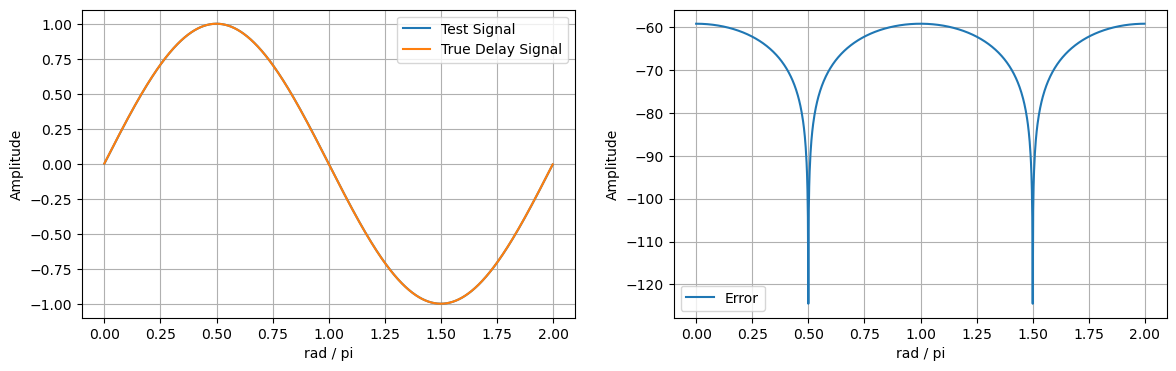

In [3]:
error = np.abs(x - x_delay_true)
error_dB = 20*np.log10(np.abs(error)+1e-20)
x_axis = 2*F*n

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(14, 4))
ax1.plot(x_axis, x, label="Test Signal")
ax1.plot(x_axis, x_delay_true, label="True Delay Signal")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("rad / pi")
ax1.legend()
ax1.grid()

ax2.plot(x_axis, error_dB, label="Error")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("rad / pi")
ax2.legend()
ax2.grid()

## Taylor Approximation

In [4]:
def frac_delay_1st(x, delta, kernel):
    """
    Single-term Taylor fractional delay: y = f + δ·f', where f' is conv(x, kernel).
    kernel must sum to zero and approximate the derivative.
    """
    f0 = x
    f1 = np.convolve(x, kernel, mode='same')
    return f0 + delta*f1

def frac_delay_2nd(x, delta, kernel):
    """
    Single-term Taylor fractional delay: y = f + δ·f', where f' is conv(x, kernel).
    kernel must sum to zero and approximate the derivative.
    """
    f0 = x
    f1 = np.convolve(x, kernel[0], mode='same')
    f2 = np.convolve(x, kernel[1], mode='same')
    return f0 + delta*f1 + delta**2*f2/2

k3 = np.array([0.5, 0.0, -0.5])
k5 = np.array([-1, 8, 0, -8, +1]) / 12.0
k7 = np.array([1, -9, +45, 0, -45, +9, -1]) / 60.0
k9 = np.array([-1, 12, -39, +56, 0, -56, +39, -12, +1]) / 280.0

k2_3 = np.array([  1.0, -2.0,  1.0 ])
k2_5 = np.array([-1,  16, -30,  16, -1]) / 12.0
k2_7 = np.array([2.0, -27.0, 270.0, -490.0, 270.0, -27.0, 2.0 ]) / 180.0
k2_9 = np.array([ -1/560.0, 8/315.0, -1/5.0, 8/5.0, -205/72.0, 8/5.0, -1/5.0, 8/315.0, -1/560.0])

## Farrow Filter

In [5]:
# C0 = np.array([-0.1667, 0.5, -0.5, 0.1667])
# C1 = np.array([0.5, -1, 0.5, 0])
# C2 = np.array([-0.3333, -0.5, 1, -1.1667])
# C3 = np.array([0, 1, 0, 0])
# C = [C0, C1, C2, C3]

# # Reverse each Ci to get Hi
# H = [np.flip(Ci) for Ci in C]
# # # Display H
# # for i, Hi in enumerate(H):
# #     print(f"H{i} =", Hi)

# def firrow_filter(x, delta):
#     C0 = np.array([-0.1667, 0.5, -0.5, 0.1667])
#     C1 = np.array([0.5, -1, 0.5, 0])
#     C2 = np.array([-0.3333, -0.5, 1, -1.1667])
#     C3 = np.array([0, 1, 0, 0])
#     C = [C0, C1, C2, C3]
#     # Reverse each Ci to get Hi
#     H = [np.flip(Ci) for Ci in C]

#     y0 = signal.lfilter(H[0], 1.0, x)
#     y1 = signal.lfilter(H[1], 1.0, x)
#     y2 = signal.lfilter(H[2], 1.0, x)
#     y3 = signal.lfilter(H[3], 1.0, x)

#     y = y3 + delta*(y2 + delta*(y1 + delta*y0))
        
#     return y


def _compute_farrow_C(M):
    """
    Compute the (M+1)x(M+1) Lagrange–Farrow coefficient matrix
    on nodes 0,1,...,M; rows are powers of delta ascending (0..M).
    """
    # 1) build Vandermonde-style basis:
    nodes = np.arange(M+1)
    Cmat  = np.zeros((M+1, M+1), dtype=float)
    for k in range(M+1):
        # numerator poly: ∏_{i≠k}(D - i)
        roots = [n for n in nodes if n != k]
        p     = np.poly(roots)  # p[0]*D^M + ... + p[M]
        # denominator: ∏_{i≠k}(k - i)
        denom = np.prod([k - i for i in roots])
        # fill out Cmat[m, k] = coefficient of D^m divided by denom
        for m in range(M+1):
            Cmat[m, k] = p[-1-m] / denom
    return Cmat

def taylor_farrow_C_kernels(M):
    """
    Return the list [C0, C1, …, CM] of length-(M+1) kernels
    for the Taylor–series Farrow filter of order M.
    """
    N     = M + 1
    shift = M // 2
    # sample‐point offsets so that tap i=shift ↔ current sample
    x = np.arange(N) - shift

    # build Vandermonde: A[k,i] = x[i]**k
    A = np.vstack([x**k for k in range(N)])
    Cmat = np.zeros((N, N))
    for p in range(N):
        # RHS: derivative constraint b[k] = k! if k==p else 0
        b = np.zeros(N)
        b[p] = math.factorial(p)
        Cmat[p] = np.linalg.solve(A, b)

    # reorder & normalize: C0 ↔ row M/ M!, C1 ↔ row M-1/(M-1)!, …, CM ↔ row 0/0!
    C_kernels = []
    for p in range(N):
        krow = Cmat[M - p] / math.factorial(M - p)
        C_kernels.append(krow)
    return C_kernels

def farrow_taylor_filter(x, delta, order):
    """
    Taylor–series‐based Farrow filter of arbitrary order (up to 5).
      x     : input 1D signal
      delta : fractional delay (0 <= delta <= order)
      order : polynomial order M

    Returns y[n] ≈ x[n-delta].
    """
    M = order
    Ck = taylor_farrow_C_kernels(M)
    # flip for causal convolution
    H  = [c[::-1] for c in Ck]
    # run each sub-filter
    y_parts = [scipy.signal.lfilter(h, 1.0, x) for h in H]

    # nested recombination: y = y_parts[M] + δ·y_parts[M-1] + δ²·y_parts[M-2] + …
    y = np.zeros_like(x, dtype=float)
    for p, yp in enumerate(y_parts):
        exponent = M - p
        y += (delta**exponent) * yp
    return y

## Methods Comparison

In [6]:
N = 1024
n = np.arange(N)
delta = 1/(8*8*32)
Fs = np.arange(1, N//2-1) / N

k1_list = [k3, k5, k7]
k2_list = [k2_3, k2_5, k2_7]

Err_1st = np.zeros((len(k1_list), Fs.size))
for i, k1 in enumerate(k1_list):
    for idx, F in enumerate(Fs):
        x       = np.sin(2*np.pi*F * n)
        x_delay = np.sin(2*np.pi*F * (n + delta))
        y       = frac_delay_1st(x, delta, k1)
        err     = 20*np.log10(np.abs(y - x_delay) + 1e-25)
        Err_1st[i, idx] = np.max(err[5:-5])

# Pre-allocate: shape (3, 3, len(Fs))
Err_2nd = np.zeros((len(k1_list), len(k2_list), Fs.size))

for i, k1 in enumerate(k1_list):
    for j, k2 in enumerate(k2_list):
        # for each F, compute and store the max error
        for idx, F in enumerate(Fs):
            x       = np.sin(2*np.pi*F * n)
            x_delay = np.sin(2*np.pi*F * (n + delta))
            y       = frac_delay_2nd(x, delta, [k1, k2])
            err     = 20*np.log10(np.abs(y - x_delay) + 1e-25)
            Err_2nd[i, j, idx] = np.max(err[5:-5])

orders = [1, 2, 3, 4, 5]
Err_Farrow = np.zeros((len(orders), Fs.size))
for i, order in enumerate(orders):
    for idx, F in enumerate(Fs):
        x       = np.sin(2*np.pi*F * n)
        x_delay = np.sin(2*np.pi*F * (n + delta))
        y = farrow_taylor_filter(np.concatenate((x, x[:order//2+1])), delta, order)
        y = y[order//2+1:]
        err     = 20*np.log10(np.abs(y - x_delay) + 1e-25)
        Err_Farrow[i, idx] = np.max(err[5:-5])

print(Err_1st.shape)
print(Err_2nd.shape)
print(Err_Farrow.shape)
np.savetxt("Err_1st.txt", Err_1st)
np.savetxt("Err_2nd.txt", Err_2nd.reshape(-1, Err_2nd.shape[2]))

(3, 510)
(3, 3, 510)
(5, 510)


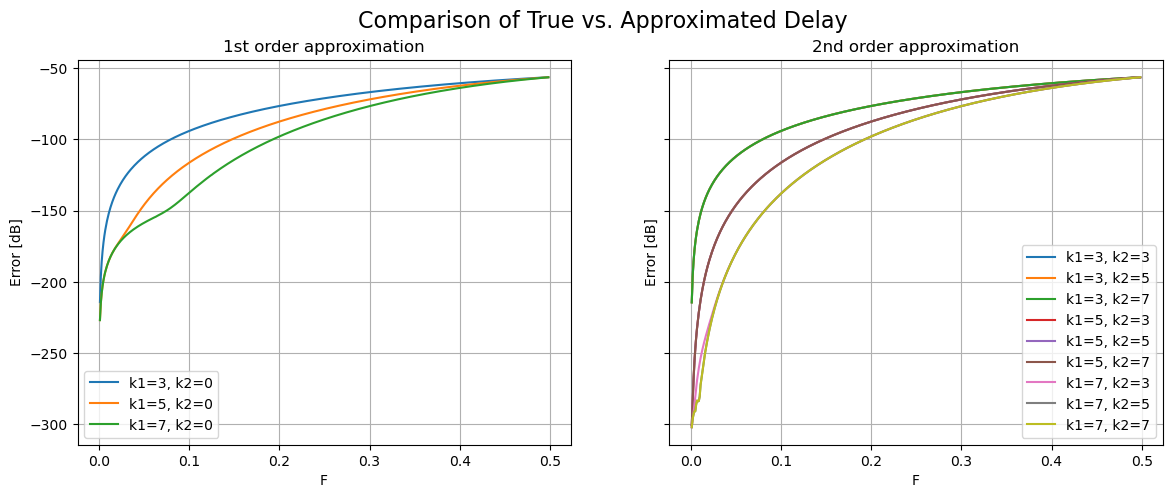

In [7]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(14, 4))
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    sharex=True,
    sharey=True,      # ← add this
    figsize=(14, 5)
)

for i, err in enumerate(Err_1st):
    ax1.plot(Fs, err, label=f"k1={2*i+3}, k2={0}")
ax1.set_title("1st order approximation")
ax1.set_ylabel("Error [dB]")
ax1.set_xlabel("F")
ax1.legend()
ax1.grid()

for i, err_i in enumerate(Err_2nd):
    for j, err in enumerate(err_i):
        ax2.plot(Fs, err, label=f"k1={2*i+3}, k2={2*j+3}")
ax2.set_title("2nd order approximation")
ax2.set_ylabel("Error [dB]")
ax2.set_xlabel("F")
ax2.legend()
ax2.grid()

# for i, err in enumerate(Err_Farrow):
#     ax3.plot(Fs, err, label=f"k={i+1}")
# ax3.set_title("Farrow filter")
# ax3.set_ylabel("Error [dB]")
# ax3.set_xlabel("F")
# ax3.legend()
# ax3.grid()

# Now both subplots will always use the same x- and y-limits:
fig.suptitle("Comparison of True vs. Approximated Delay", fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

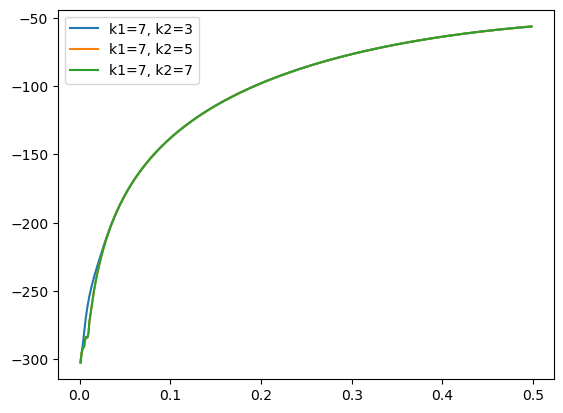

In [8]:
for j, err in enumerate(Err_2nd[2]):
    plt.plot(Fs, err, label=f"k1={2*i+3}, k2={2*j+3}")
plt.legend()

In [9]:
h = [ +1/280,  -4/105,  +1/5,  -4/5,  0,
      +4/5,    -1/5,    +4/105,  -1/280 ]

k1_list = [h]


Err_1st = np.zeros((len(k1_list), Fs.size))
for i, k1 in enumerate(k1_list):
    for idx, F in enumerate(Fs):
        x       = np.sin(2*np.pi*F * n)
        x_delay = np.sin(2*np.pi*F * (n + delta))
        y       = frac_delay_1st(x, delta, k1)
        err     = 20*np.log10(np.abs(y - x_delay) + 1e-25)
        Err_1st[i, idx] = np.max(err[5:-5])

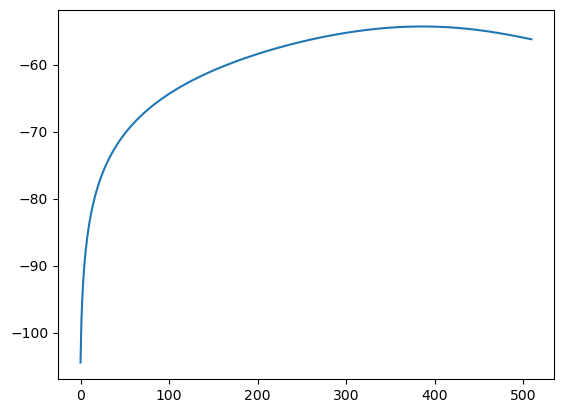

In [10]:
plt.plot(Err_1st[0])